In [2]:
import scanpy as sc
import sys
sys.path.append('/wsfish/glioblastoma/')
import FISHspace as sp
from scipy.spatial import KDTree
import numpy as np
import squidpy as sq
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# make font changeable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style

In [3]:
adata = sc.read_h5ad('../GBM_Linnarsson_EEL.h5ad')
#adata_tumor_sc.X = adata_tumor_sc.layers['smooth']

In [4]:
rename_dic = {
    'GW-like 5':'GW-like Endo.Ass.',
    'GW-like 2':'GW-like Periphery1',
    'GW-like 3':'GW-like Periphery2',
    'GW-like 1':'GW-like Periphery3',
    
    'GW-like 6':'GW-like HYPR1',
    'GW-like 8':'GW-like HYPR2',
    'GW-like 7':'GW-like OPC',
    'GW-like 4':'GW-like nIPC',
    
    'nIPC-RG-like':'RG-like',
    
 
}

adata.obs['m-states3'] = pd.Categorical([rename_dic[m] if m in rename_dic else m for m in adata.obs['m-states2']])

In [5]:
adata.obs['m-states3'] = ['Endothelial' if ms.count('Endothelial') else ms for ms in adata.obs['m-states3']]
adata.obs['m-states3'] = ['Oligodendrocyte' if ms.count('Oligodendrocyte') else ms for ms in adata.obs['m-states3']]
adata.obs['m-states3'] = pd.Categorical(['Mural cell' if ms.count('Mural') else ms for ms in adata.obs['m-states3']])

In [6]:
adata.obs['m-states3'].cat.categories

Index(['AC-like 1', 'AC-like 2', 'AC-like 3', 'AC-like 4', 'AC-like 5',
       'AC-like 6', 'AC-like 7', 'Astrocyte', 'DC', 'Endothelial',
       'Erythrocyte 1', 'FB-like 1', 'FB-like 2', 'FB-like 3', 'GBL-like 1',
       'GBL-like 2', 'GW-like Endo.Ass.', 'GW-like HYPR1', 'GW-like HYPR2',
       'GW-like OPC', 'GW-like Periphery1', 'GW-like Periphery2',
       'GW-like Periphery3', 'GW-like nIPC', 'Mono 1', 'Mono 2', 'Mural cell',
       'OPC-like 1', 'OPC-like 2', 'Oligodendrocyte', 'RG-like', 'TAM-BDM 1',
       'TAM-BDM 2', 'TAM-BDM 3', 'TAM-BDM 4', 'TAM-MG', 'nIPC-like 1',
       'nIPC-like 2', 'nIPC-like 3', 'preOPC-like 1', 'unknown 1',
       'unknown2 1'],
      dtype='object')

In [7]:
palette = {
    'AC-like 1':'#2ecc71',#inchworm B4FF9F
    'AC-like 2':'#2ecc71',#inchworm B4FF9F
    'AC-like 3':'#2ecc71',#inchworm B4FF9F
    'AC-like 4':'#2ecc71',#inchworm B4FF9F
    'AC-like 5':'#2ecc71',#inchworm B4FF9F
    'AC-like 6':'#2ecc71',#inchworm B4FF9F
    'AC-like 7':'#2ecc71',#inchworm B4FF9F
    'AC-like 8':'#2ecc71',#inchworm B4FF9F

    'preOPC-like 1':'#7befb2',#'#c2f970'

    'GW-like Endo.Ass.':'#e76d89',# Deep cerise
    'GW-like Periphery1':'#e76d89',# Deep cerise
    'GW-like Periphery2':'#e76d89',# Deep cerise
    'GW-like Periphery3':'#e76d89',# Deep cerise
    'GW-like HYPR1':'#e76d89',# Deep cerise
    'GW-like HYPR2':'#e76d89',# Deep cerise
    'GW-like nIPC':'#e76d89',# Deep cerise
    'GW-like OPC':'#e76d89',# Deep cerise
    
    'GBL-like 1':'#c2f970',
    'GBL-like 2':'#c2f970',
    
    #'nIPC-like 1':'#FFF192',
    #'nIPC-like 2':'#FFF192',
    #'nIPC-like 3':'#FFF192',
    
    'RG-like':'#ff9470',
    'nIPC-RG-like':'#ff9470',
    
    'OPC-like 1':'#89c4f4', #bright turquoise
    'OPC-like 2':'#89c4f4', #bright turquoise
    
    'TAM-BDM 1':'#e3ba8f', #wood
    'TAM-BDM 2':'#e3ba8f',
    'TAM-BDM 3':'#e3ba8f',
    'TAM-BDM 4':'#e3ba8f', #wood

    'TAM-MG':'#a6915c',#red orange
    'Mono 1': '#f4ede4',
    'Mono 2': '#f4ede4',
    
    'Oligodendrocyte':'#392e4a',
    'Astrocyte':'#038aff',
    
    #'Endothelial':'#d5b8ff', #mauve
    'Mural cell': '#8c14fc',  #electric indigo
    #'Mural': '#8c14fc',  #electric indigo
    
    'Endothelial': '#d5b8ff',  

    #'FB-like 1': '#9f5afd', #fff9de
    'FB-like 2': '#9f5afd', #fff9de
    'FB-like 3': '#9f5afd', #fff9de

}

INFO:root:First filter, 180933 cells left
INFO:root:Selecting cells in zoom area
INFO:root:Zoom filter, 7820 cells left


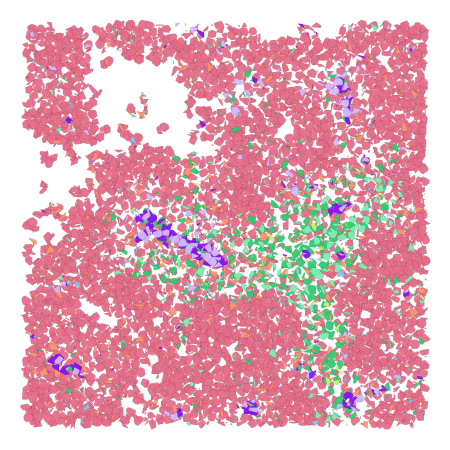

In [8]:
sp.pl.plot_polygons(
    adata,
    sample='SL035B',
    palette=palette,
    cluster_key= 'm-states3',
    clusters = ['GW-like HYPR1', 'GW-like HYPR2', 'AC-like 3','GBL-like 2', 'RG-like', 'OPC-like 1', 'OPC-like 2', 'preOPC-like 1', 'Mural cell','Endothelial'],
    
    xlim = (11000, 13000),
    ylim= (5000, 7000),
    figsize=(5,5),
    dpi=300,
    alpha=.95,
    show_scalebar=False,
    
    save=True,
    savepath='figures/SL035B_zoom.svg',
    
)

In [ ]:
sp.pl.plot_polygons(
    adata,
    sample='SL046B',
    palette=palette,
    cluster_key= 'm-states3',
    clusters = ['GW-like HYPR1', 'GW-like HYPR2', 'AC-like 3','GBL-like 2', 'RG-like', 'OPC-like 1', 'OPC-like 2', 'GBL-like 1','GBL-like 1','preOPC-like 1', 'Mural cell','Endothelial'],
    
    xlim= (7500,9000),
    ylim= (6000,7500),
    show_axis=False,
    figsize=(5,5),
    dpi=300,
    alpha=.95,
    show_scalebar=True,
    
    save=True,
    savepath='figures/SL046B_zoom.svg',
    
)

INFO:root:First filter, 76517 cells left
INFO:root:Selecting cells in zoom area


In [1]:
adatasp.pl.plot_polygons(
    adata,
    sample='SL035B',
    palette=palette,
    cluster_key= 'm-states3',
    clusters = ['GW-like HYPR1', 'GW-like HYPR2', 'AC-like 3','GBL-like 2', 'RG-like', 'OPC-like 1', 'OPC-like 2', 'preOPC-like 1', 'Mural cell','Endothelial'],
    
    xlim = (11000, 13000),
    ylim= (5000, 7000),
    figsize=(5,5),
    dpi=300,
    alpha=.95,
    show_scalebar=False,
    
    save=True,
    savepath='figures/SL035B_zoom.svg',
    
)

NameError: name 'adata' is not defined

INFO:root:First filter, 124430 cells left
INFO:root:Selecting cells in zoom area
INFO:root:Zoom filter, 25654 cells left


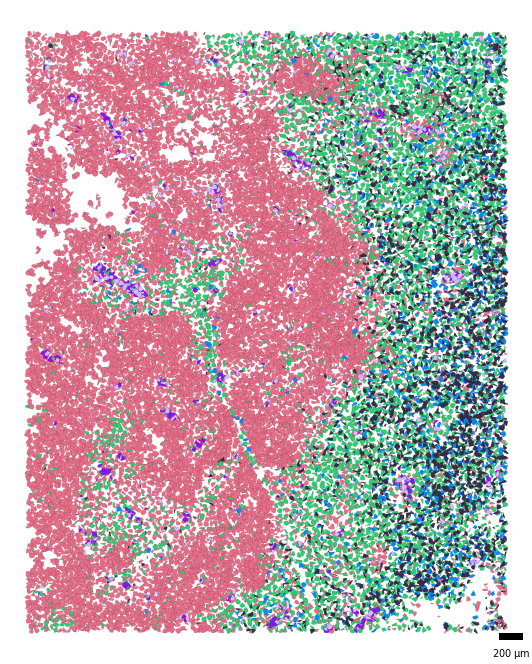

In [59]:
sp.pl.plot_polygons(
    adata,
    sample='SL035B',
    palette=palette,
    cluster_key= 'm-states3',
    clusters = ['GW-like HYPR1', 'GW-like HYPR2', 'AC-like 3','Mural cell','Endothelial', 'Astrocyte', 'Oligodendrocyte'],
    grey_clusters = ['MES-like'],
    xlim = (11000, 15000),
    ylim= (3000, 8000),
    figsize=(6,7),
    dpi=300,
    area_min_size=150,
    alpha=1,
    show_scalebar=True,
    #save=True,
    #savepath='figures/SL035B_border.svg',
)

INFO:root:First filter, 146625 cells left
INFO:root:Selecting cells in zoom area
INFO:root:Zoom filter, 17746 cells left


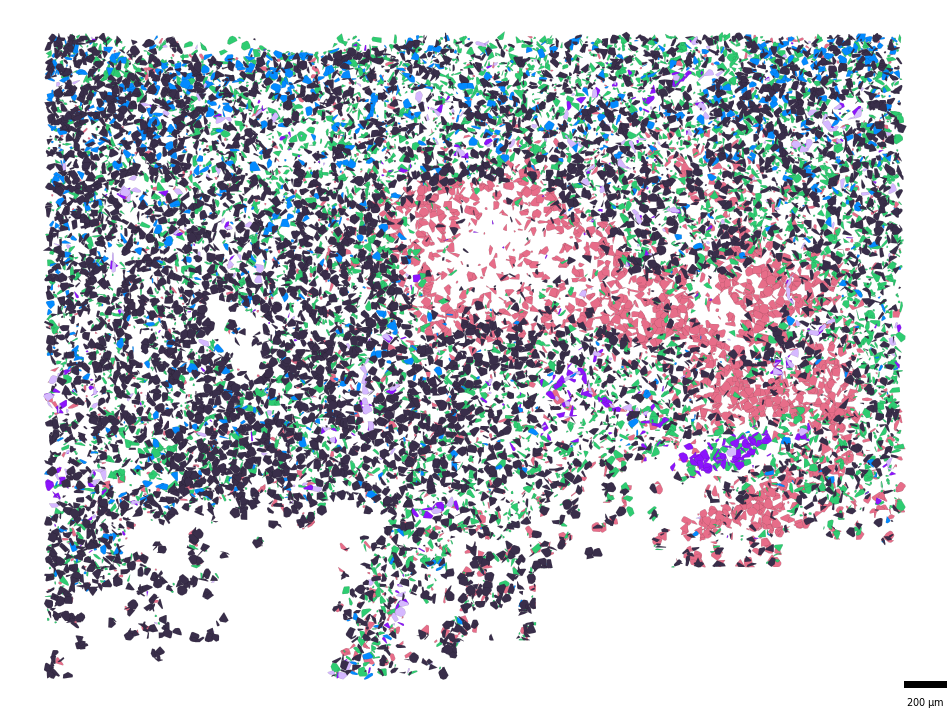

In [66]:
sp.pl.plot_polygons(
    adata,
    sample='SL046C',
    cluster_key='m-states3',
    clusters = ['GW-like HYPR1', 'GW-like HYPR2', 'AC-like 1', 'AC-like 2','AC-like 3','AC-like 4','AC-like 5','AC-like 6','AC-like 7','Mural cell','Endothelial', 'Astrocyte', 'Oligodendrocyte'],
    #grey_clusters= adata.obs['m-states3'].cat.categories.tolist(),
    #alpha_gray=.9,
    xlim=(6000,10000),
    ylim=(1000,4000),

    show_axis=False,
    palette=palette,
    figsize=(10,10),
    alpha=1,
    #facecolor=(0,0,0),

    area_min_size=50,
    fontsize=12,
    annotation_rotation=-90,
    annotation_text_offset=(50,-300),
    save=True,
    savepath='figures/SL046C_zoom.svg',   
)

INFO:root:First filter, 117355 cells left
INFO:root:Selecting cells in zoom area
INFO:root:Zoom filter, 6048 cells left


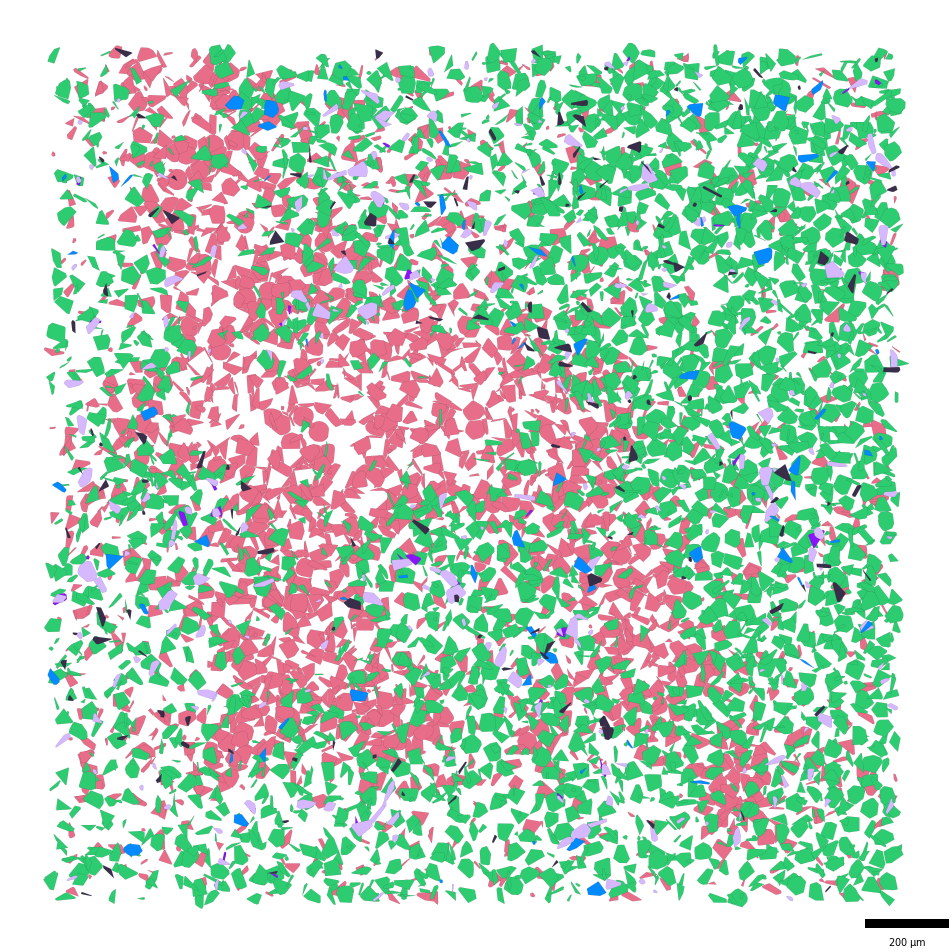

In [67]:
sp.pl.plot_polygons(
    adata,
    sample='SL061B',
    cluster_key='m-states3',
    clusters = ['GW-like HYPR1', 'GW-like HYPR2', 'AC-like 1', 'AC-like 2','AC-like 3','AC-like 4','AC-like 5','AC-like 6','AC-like 7','Mural cell','Endothelial', 'Astrocyte', 'Oligodendrocyte'],
    #grey_clusters= adata.obs['m-states3'].cat.categories.tolist(),
    #alpha_gray=.9,
    xlim = (4000,6000),
    ylim = (4000,6000),
    show_axis=False,
    palette=palette,
    figsize=(10,10),
    alpha=1,
    #facecolor=(0,0,0),

    area_min_size=50,
    fontsize=12,
    annotation_rotation=-90,
    annotation_text_offset=(50,-300),
    save=True,
    savepath='figures/SL061B_zoom.svg',   
)

In [ ]:
sp.pl.plot_polygons(
    adata,
    sample='SL061B',
    palette=palette,
    cluster_key= 'm-states3',
    clusters = ['GW-like HYPR1', 'GW-like HYPR2', 'AC-like 3','Mural cell','Endothelial', 'Astrocyte', 'Oligodendrocyte'],
    grey_clusters = ['MES-like'],
    #xlim = (11000, 15000),
    #ylim= (3000, 8000),
    figsize=(6,6),
    dpi=300,
    area_min_size=150,
    alpha=1,

    show_scalebar=False,
    
    save=True,
    savepath='figures/SL061B_border.svg',
)

INFO:root:First filter, 59224 cells left
INFO:root:Zoom filter, 59224 cells left


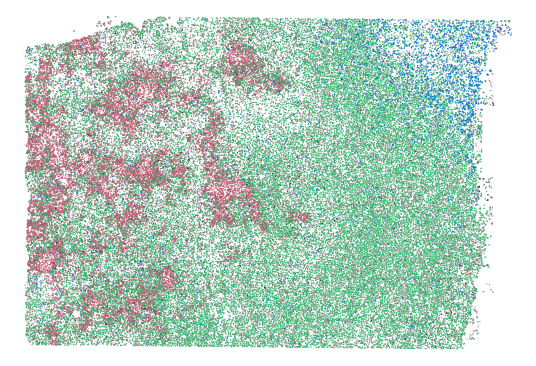

In [40]:
sp.pl.plot_polygons(
    adata,
    sample='SL061B',
    palette=palette,
    cluster_key= 'm-states3',
    clusters = ['GW-like HYPR1', 'GW-like HYPR2', 'AC-like 3','Mural cell','Endothelial', 'Astrocyte', 'Oligodendrocyte'],
    grey_clusters = ['MES-like'],
    #xlim = (11000, 15000),
    #ylim= (3000, 8000),
    figsize=(6,6),
    dpi=300,
    area_min_size=150,
    alpha=1,

    show_scalebar=False,
    
    save=True,
    savepath='figures/SL061B_border.svg',
)

INFO:root:First filter, 7673 cells left
INFO:root:Selecting cells in zoom area
INFO:root:Zoom filter, 60 cells left


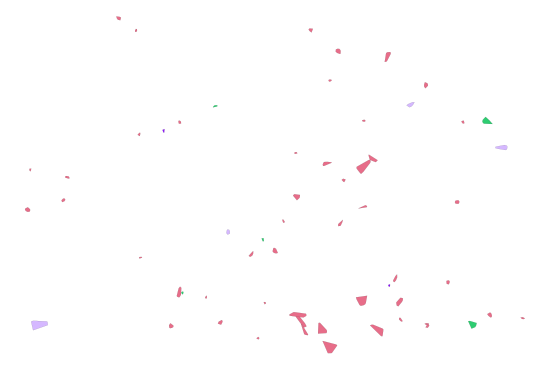

In [45]:
sp.pl.plot_polygons(
    adata,
    sample='SL001B',
    palette=palette,
    cluster_key= 'm-states3',
    clusters = ['Mural cell','Endothelial','GW-like HYPR1', 'GW-like HYPR2', 'AC-like 3'],
    
    xlim=(3500,5000),
    ylim=(1800,2800),
    figsize=(6,6),
    dpi=300,
    #area_min_size=150,
    alpha=1,

    show_scalebar=False,
    
    save=True,
    savepath='figures/SL001B.svg',
)


INFO:root:First filter, 74100 cells left
INFO:root:Selecting cells in zoom area
INFO:root:Zoom filter, 1886 cells left


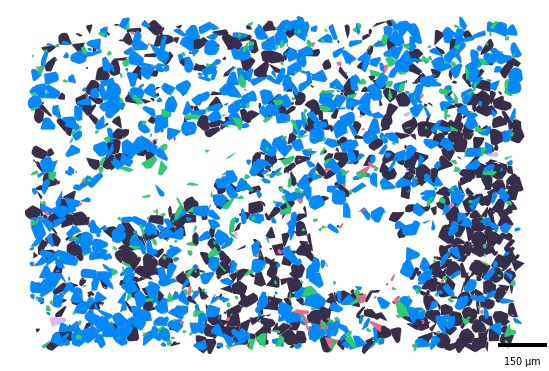

In [68]:
sp.pl.plot_polygons(
    adata,
    sample='SL001B',
    palette=palette,
    cluster_key= 'm-states3',
    clusters = [ 'Oligodendrocyte','Astrocyte','Mural cell','Endothelial','GW-like HYPR1', 'GW-like HYPR2', 'AC-like 3','AC-like 5', 'AC-like 6','AC-like 7',],
    
    xlim=(3500,5000),
    ylim=(1800,2800),
    figsize=(6,6),
    dpi=300,
    #area_min_size=150,
    alpha=1,

    show_scalebar=True,
    
    save=True,
    savepath='figures/SL001B_zoom.svg',
)


In [ ]:
sp.pl.plot_polygons(
    adata,
    sample='SL046B',
    palette=palette,
    cluster_key= 'm-states3',
    clusters = [ 'Oligodendrocyte','Astrocyte','Mural cell','Endothelial','GW-like HYPR1', 'GW-like HYPR2', 'AC-like 3'],
    
    xlim=(3500,5000),
    ylim=(1800,2800),
    figsize=(6,6),
    dpi=300,
    #area_min_size=150,
    alpha=1,

    show_scalebar=True,
    
    save=True,
    savepath='figures/SL001B_zoom.svg',
)


INFO:root:First filter, 78049 cells left
INFO:root:Selecting cells in zoom area
INFO:root:Zoom filter, 1828 cells left


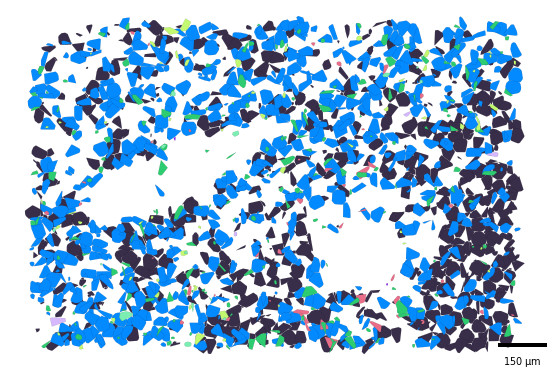

In [52]:
sp.pl.plot_polygons(
    adata,
    sample='SL001B',
    palette=palette,
    cluster_key= 'm-states3',
    clusters = [ 'Oligodendrocyte','Astrocyte','Mural cell','Endothelial','GW-like HYPR1', 'GW-like HYPR2', 'AC-like 3','AC-like 5','AC-like 6', 'GBL-like 1', 'preOPC-like 1'],
    
    xlim=(3500,5000),
    ylim=(1800,2800),
    figsize=(6,6),
    dpi=300,
    #area_min_size=150,
    alpha=1,

    show_scalebar=True,
    
    save=True,
    savepath='figures/SL001B_zoom.svg',
)

In [ ]:
sp.pl.plot_polygons(
    adata,
    sample='SL035B',
    palette=palette,
    cluster_key= 'm-states3',
    clusters = ['GW-like HYPR1', 'GW-like HYPR2', 'AC-like 3','GBL-like 2', 'RG-like', 'OPC-like 1', 'OPC-like 2', 'preOPC-like 1', 'Mural cell','Endothelial'],
    grey_clusters = ['MES-like'],
    xlim = (11000, 14500),
    ylim= (3000, 8000),
    figsize=(5,5),
    dpi=300,
    area_min_size=150,
    alpha=.95,
    show_scalebar=False,
    
    save=True,
    savepath='figures/SL035B_border.svg',
)